# NSGA-II baseline on ZDT (high dimensionality)

Updated baseline table with provided NSGA-II and AutoNSGA-II timings/evaluations.

In [1]:
from __future__ import annotations
import pandas as pd
from IPython.display import display

## Table 3: NSGA-II vs AutoNSGA-II settings

Configuration values needed to reproduce the ZDT runs (from the AutoNSGA-II paper). We'll reuse them when launching NSGA-II/AutoNSGA-II jobs.

In [2]:
NSGAII_DEFAULT_CONFIG = {
    "algorithmResult": "population",
    "populationSize": 100,
    "offspringPopulationSize": 100,
    "variation": "crossoverAndMutationVariation",
    "crossover": "SBX",
    "crossoverProbability": 0.9,
    "crossoverRepairStrategy": "random",
    "sbxDistributionIndexValue": 20.0,
    "mutation": "polynomial",
    "mutationProbabilityFactor": 1.0,
    "mutationRepairStrategy": "random",
    "polynomialMutationDistributionIndex": 20.0,
    "selection": "tournament",
    "selectionTournamentSize": 2,
}

AUTONSGAII_CONFIG = {
    "algorithmResult": "externalArchive",
    "populationSizeWithArchive": 56,
    "offspringPopulationSize": 14,
    "variation": "crossoverAndMutationVariation",
    "crossover": "BLX_ALPHA",
    "crossoverProbability": 0.88,
    "crossoverRepairStrategy": "bounds",
    "blxAlphaCrossoverAlphaValue": 0.94,
    "mutation": "nonUniform",
    "mutationProbabilityFactor": 0.45,
    "mutationRepairStrategy": "round",
    "nonUniformMutationPerturbation": 0.3,
    "selection": "tournament",
    "selectionTournamentSize": 9,
}

CONFIG_TABLE = [
    ("algorithmResult", NSGAII_DEFAULT_CONFIG["algorithmResult"], AUTONSGAII_CONFIG["algorithmResult"]),
    ("populationSize / populationSizeWithArchive", NSGAII_DEFAULT_CONFIG["populationSize"], AUTONSGAII_CONFIG["populationSizeWithArchive"]),
    ("offspringPopulationSize", NSGAII_DEFAULT_CONFIG["offspringPopulationSize"], AUTONSGAII_CONFIG["offspringPopulationSize"]),
    ("variation", NSGAII_DEFAULT_CONFIG["variation"], AUTONSGAII_CONFIG["variation"]),
    ("crossover", NSGAII_DEFAULT_CONFIG["crossover"], AUTONSGAII_CONFIG["crossover"]),
    ("crossoverProbability", NSGAII_DEFAULT_CONFIG["crossoverProbability"], AUTONSGAII_CONFIG["crossoverProbability"]),
    ("crossoverRepairStrategy", NSGAII_DEFAULT_CONFIG["crossoverRepairStrategy"], AUTONSGAII_CONFIG["crossoverRepairStrategy"]),
    ("sbxDistributionIndexValue / blxAlphaCrossoverAlphaValue", NSGAII_DEFAULT_CONFIG["sbxDistributionIndexValue"], AUTONSGAII_CONFIG["blxAlphaCrossoverAlphaValue"]),
    ("mutation", NSGAII_DEFAULT_CONFIG["mutation"], AUTONSGAII_CONFIG["mutation"]),
    ("mutationProbabilityFactor", NSGAII_DEFAULT_CONFIG["mutationProbabilityFactor"], AUTONSGAII_CONFIG["mutationProbabilityFactor"]),
    ("mutationRepairStrategy", NSGAII_DEFAULT_CONFIG["mutationRepairStrategy"], AUTONSGAII_CONFIG["mutationRepairStrategy"]),
    ("polynomialMutationDistributionIndex / nonUniformMutationPerturbation", NSGAII_DEFAULT_CONFIG["polynomialMutationDistributionIndex"], AUTONSGAII_CONFIG["nonUniformMutationPerturbation"]),
    ("selection", NSGAII_DEFAULT_CONFIG["selection"], AUTONSGAII_CONFIG["selection"]),
    ("selectionTournamentSize", NSGAII_DEFAULT_CONFIG["selectionTournamentSize"], AUTONSGAII_CONFIG["selectionTournamentSize"]),
]
config_df = pd.DataFrame(CONFIG_TABLE, columns=["Setting", "NSGA-II (default)", "AutoNSGA-II"])
display(config_df)


,Setting,NSGA-II (default),AutoNSGA-II
0,algorithmResult,population,externalArchive
1,populationSize / populationSizeWithArchive,100,56
2,offspringPopulationSize,100,14
3,variation,crossoverAndMutationVariation,crossoverAndMutationVariation
4,crossover,SBX,BLX_ALPHA
5,crossoverProbability,0.9,0.88
6,crossoverRepairStrategy,random,bounds
7,sbxDistributionIndexValue / blxAlphaCrossoverA...,20.0,0.94
8,mutation,polynomial,nonUniform
9,mutationProbabilityFactor,1.0,0.45


In [3]:


def _record(problem, variables, time_nsga, time_auto, evals_nsga, evals_auto):
    return {
        "Problem": problem,
        "Variables": variables,
        "Time (h) NSGA-II": time_nsga,
        "Time (h) AutoNSGA-II": time_auto,
        "Evaluations NSGA-II": evals_nsga,
        "Evaluations AutoNSGA-II": evals_auto,
        "AutoNSGA-II-Nico": "-",
    }


BASELINE_RECORDS = [
    _record("ZDT1", 2_048, 0.13, 0.02, 1_250_500, 182_356),
    _record("ZDT1", 4_096, 0.51, 0.12, 2_906_100, 484_356),
    _record("ZDT1", 8_192, 2.40, 0.50, 6_622_600, 1_039_156),
    _record("ZDT1", 16_384, 11.19, 2.15, 14_741_200, 2_180_656),
    _record("ZDT1", 32_768, None, 9.04, None, 4_605_556),
    _record("ZDT1", 65_356, None, 31.66, None, 9_494_556),
    _record("ZDT1", 131_072, None, 120.02, None, 19_359_356),
    _record("ZDT2", 2_048, 0.14, 0.02, 1_472_800, 164_756),
    _record("ZDT2", 4_096, 0.62, 0.10, 3_433_100, 429_156),
    _record("ZDT2", 8_192, 2.77, 0.49, 7_676_600, 986_556),
    _record("ZDT2", 16_384, 12.30, 2.28, 17_059_600, 2_358_056),
    _record("ZDT2", 32_768, None, 9.28, None, 4_736_056),
    _record("ZDT2", 65_356, None, 39.19, None, 10_081_856),
    _record("ZDT2", 131_072, None, 138.85, None, 21_703_556),
    _record("ZDT3", 2_048, 0.10, 0.03, 1_089_800, 253_356),
    _record("ZDT3", 4_096, 0.47, 0.16, 2_514_200, 610_956),
    _record("ZDT3", 8_192, 2.08, 0.62, 5_463_000, 1_267_656),
    _record("ZDT3", 16_384, 9.18, 2.68, 11_877_500, 2_820_556),
    _record("ZDT3", 32_768, None, 11.39, None, 6_158_256),
    _record("ZDT3", 65_356, None, 40.69, None, 11_912_856),
    _record("ZDT3", 131_072, None, None, None, None),
    _record("ZDT4*", 2_048, None, 2.62, None, 21_746_882),
    _record("ZDT6", 2_048, 0.45, 0.04, 5_401_100, 291_856),
    _record("ZDT6", 4_096, 1.82, 0.16, 11_482_400, 659_956),
    _record("ZDT6", 8_192, 7.16, 0.66, 24_897_300, 1_374_056),
    _record("ZDT6", 16_384, None, 3.08, None, 3_221_156),
    _record("ZDT6", 32_768, None, 15.51, None, 7_941_156),
    _record("ZDT6", 65_356, None, 63.79, None, 17_685_556),
    _record("ZDT6", 131_072, None, None, None, None),
]
baseline_df = pd.DataFrame(BASELINE_RECORDS)
display(baseline_df)



,Problem,Variables,Time (h) NSGA-II,Time (h) AutoNSGA-II,Evaluations NSGA-II,Evaluations AutoNSGA-II,AutoNSGA-II-Nico
0,ZDT1,2048,0.13,0.02,1250500.0,182356.0,-
1,ZDT1,4096,0.51,0.12,2906100.0,484356.0,-
2,ZDT1,8192,2.40,0.50,6622600.0,1039156.0,-
3,ZDT1,16384,11.19,2.15,14741200.0,2180656.0,-
4,ZDT1,32768,NaN,9.04,NaN,4605556.0,-
5,ZDT1,65356,NaN,31.66,NaN,9494556.0,-
6,ZDT1,131072,NaN,120.02,NaN,19359356.0,-
7,ZDT2,2048,0.14,0.02,1472800.0,164756.0,-
8,ZDT2,4096,0.62,0.10,3433100.0,429156.0,-
9,ZDT2,8192,2.77,0.49,7676600.0,986556.0,-


## Launch ZDT1 (2,048 vars) with Table 3 configs
Run both the baseline NSGA-II and AutoNSGA-II settings. Adjust `max_evaluations` or `engine_name` if you need shorter/faster smoke tests.

In [4]:

import sys
from pathlib import Path

ROOT = Path.cwd()
SRC_DIR = ROOT / "src"
if SRC_DIR.exists() and str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

from vamos.problem.registry import make_problem_selection
from vamos.runner import ExperimentConfig, run_single

AUTO_RUN_CFG = {
    "label": "AutoNSGA-II (external archive)",
    "population_size": 56,
    "offspring_population_size": 14,
    "selection_pressure": 9,
    "max_evaluations": 182_356,
    "external_archive_size": 56,
    "variation": {
        "crossover": {"method": "blx_alpha", "prob": 0.88, "alpha": 0.94},
        "mutation": {"method": "non_uniform", "prob": "0.45/n", "perturbation": 0.3},
        "repair": "clip",
    },
}

RUN_RESULTS = {}
selection = make_problem_selection("zdt1", n_var=2_048)

cfg = AUTO_RUN_CFG
print(f"=== Launching {cfg['label']} (ZDT1, 2_048 vars) ===")
exp_cfg = ExperimentConfig(
    population_size=cfg["population_size"],
    offspring_population_size=cfg["offspring_population_size"],
    max_evaluations=cfg["max_evaluations"],
    seed=1,
)
metrics = run_single(
    engine_name="moocore",
    algorithm_name="nsgaii",
    selection=selection,
    config=exp_cfg,
    external_archive_size=cfg["external_archive_size"],
    selection_pressure=cfg["selection_pressure"],
    nsgaii_variation=cfg["variation"],
)
RUN_RESULTS["autonsga2"] = metrics

print("Stored run metrics keys:", list(RUN_RESULTS))



=== Launching AutoNSGA-II (external archive) (ZDT1, 2_048 vars) ===
VAMOS: Vectorized Architecture for Multiobjective Optimization Studies
Problem: ZDT1
Description: Classic bi-objective benchmark with a convex Pareto front.
Decision variables: 2048
Objectives: 2
Encoding: continuous
Algorithm: NSGAII
Backend: moocore
Population size: 56
Offspring population size: 14
Max evaluations: 182356
--------------------------------------------------------------------------------
nsgaii -> Time: 109901.11 ms | Eval/s: 1659.3
Objective 1 spread: 1.000000

Results stored in: results\ZDT1\nsgaii\moocore\seed_1
Stored run metrics keys: ['autonsga2']
nsgaii -> Time: 109901.11 ms | Eval/s: 1659.3
Objective 1 spread: 1.000000

Results stored in: results\ZDT1\nsgaii\moocore\seed_1
Stored run metrics keys: ['autonsga2']


In [5]:

RUN_RESULTS = globals().get("RUN_RESULTS", {})
if not RUN_RESULTS:
    raise RuntimeError("Run the launch cell first to populate RUN_RESULTS.")

updated_df = baseline_df.copy()
mask_zdt1_2048 = (updated_df["Problem"] == "ZDT1") & (updated_df["Variables"] == 2_048)

metrics = RUN_RESULTS.get("autonsga2")
if metrics:
    updated_df.loc[mask_zdt1_2048, "AutoNSGA-II-Nico"] = metrics["time_ms"] / 3_600_000
    updated_df.loc[mask_zdt1_2048, "Evaluations AutoNSGA-II"] = metrics["evaluations"]

baseline_df = updated_df
display(updated_df)



,Problem,Variables,Time (h) NSGA-II,Time (h) AutoNSGA-II,Evaluations NSGA-II,Evaluations AutoNSGA-II,AutoNSGA-II-Nico
0,ZDT1,2048,0.13,0.02,1250500.0,182364.0,0.030528
1,ZDT1,4096,0.51,0.12,2906100.0,484356.0,-
2,ZDT1,8192,2.40,0.50,6622600.0,1039156.0,-
3,ZDT1,16384,11.19,2.15,14741200.0,2180656.0,-
4,ZDT1,32768,NaN,9.04,NaN,4605556.0,-
5,ZDT1,65356,NaN,31.66,NaN,9494556.0,-
6,ZDT1,131072,NaN,120.02,NaN,19359356.0,-
7,ZDT2,2048,0.14,0.02,1472800.0,164756.0,-
8,ZDT2,4096,0.62,0.10,3433100.0,429156.0,-
9,ZDT2,8192,2.77,0.49,7676600.0,986556.0,-


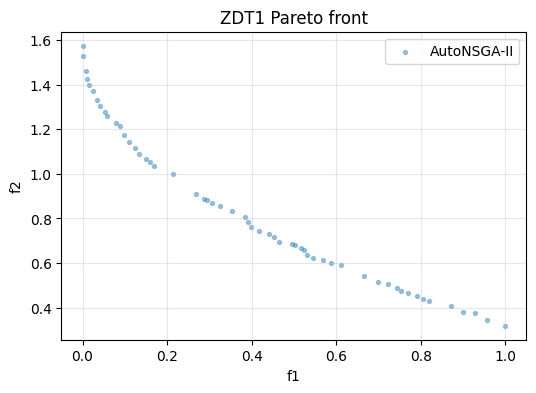

In [6]:
import numpy as np
import matplotlib.pyplot as plt

RUN_RESULTS = globals().get("RUN_RESULTS", {})
if not RUN_RESULTS:
    raise RuntimeError("Run the launch cell first to populate RUN_RESULTS.")

metrics = RUN_RESULTS.get("autonsga2")
if metrics is None:
    raise RuntimeError("AutoNSGA-II metrics not found in RUN_RESULTS.")

F = np.asarray(metrics.get("F"))
if F.size == 0 or F.ndim != 2 or F.shape[1] < 2:
    raise RuntimeError("Result F is empty or has fewer than 2 objectives; cannot plot Pareto front.")

plt.figure(figsize=(6, 4))
plt.scatter(F[:, 0], F[:, 1], s=8, alpha=0.4, label="AutoNSGA-II")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("ZDT1 Pareto front")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
